In [1]:
import tensorflow as tf
import librosa
import os
import copy
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Load style and content

In [47]:
CONTENT_FILENAME = "inputs/content/bhulaDena.mp3"
STYLE_FILENAME = "inputs/style/spongebob.mp3"
method = "mel"

In [48]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [49]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(file_name, method="stft"):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X, N_FFT))
    if method == "mfcc":
        S = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    elif method == "mel":
        S = librosa.feature.melspectrogram(X, sr=sample_rate)
    else:
        S = stft
    S = np.log1p(np.abs(S))  
    return S, sample_rate


In [50]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME, method)
a_style, fs = read_audio_spectum(STYLE_FILENAME, method)
N_SAMPLES = min(a_style.shape[1], a_content.shape[1])
N_CHANNELS = min(a_style.shape[0], a_content.shape[0])

a_style = a_style[:N_CHANNELS,:N_SAMPLES]
a_content = a_content[:N_CHANNELS,:N_SAMPLES]

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [51]:
a_content.shape

(128, 434)

### Visualize spectrograms for content and style tracks

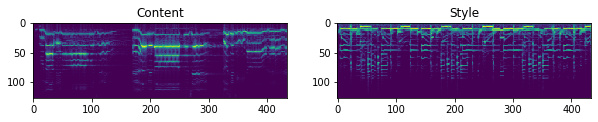

In [52]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content)
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style)
plt.show()

### Compute content and style feats

In [53]:
N_FILTERS = 4096
pool_width = 2

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
#     max_pool = tf.nn.max_pool(
#         conv,
#         ksize=[1,1,1,pool_width],
#         strides = [1,1,1,pool_width],
#         padding="VALID",
#         name="max_pool")
    max_pool = tf.reduce_max(conv, reduction_indices=[pool_width], keep_dims=True)

    
    net = tf.nn.relu(max_pool)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
#     print(features.shape)
    style_gram = np.matmul(features.T, features) / N_SAMPLES

### Optimize

In [54]:
from sys import stderr

ALPHA= 1e-2
iterations = 300
result = None
with tf.Graph().as_default():

    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
#     max_pool = tf.nn.max_pool(
#         conv,
#         ksize=[1,1,1,pool_width],
#         strides = [1,1,1,pool_width],
#         padding="VALID",
#         name="max_pool")
    
    max_pool = tf.reduce_max(conv, reduction_indices=[pool_width], keep_dims=True)
    
    net = tf.nn.relu(max_pool)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': iterations})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print('Final loss:', loss.eval())
        result = x.eval()
print(result)

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 6.450336
  Number of iterations: 96
  Number of functions evaluations: 118
Final loss: 6.4503365
[[[[ 1.87854633e-01 -2.71541685e-01  6.29182730e-04 ... -1.51159972e-01
    -8.58104676e-02 -1.66553319e-01]
   [-3.71250749e-01 -1.99996412e-01  5.65513611e-01 ... -9.92782861e-02
     2.74479568e-01 -2.40408078e-01]
   [ 2.21094921e-01 -3.53193074e-01  2.73083478e-01 ... -1.41249314e-01
    -4.06490475e-01  9.28361043e-02]
   ...
   [-1.61813959e-01  3.23700935e-01  2.70104766e-01 ...  3.11574817e-01
     3.23132396e-01 -1.86435789e-01]
   [-6.73160672e-01  2.22657397e-02  1.66319892e-01 ...  5.47047496e-01
     1.86083958e-01  1.86108887e-01]
   [-1.90217346e-01 -2.64222473e-01  1.16525635e-01 ... -1.68821424e-01
     2.39724256e-02 -1.82185713e-02]]]]


In [43]:
result

array([[[[-0.04943162,  0.01190157,  0.02896582, ..., -0.0077776 ,
          -0.00594806, -0.0151646 ],
         [ 0.03283105,  0.07335721,  0.01068449, ...,  0.01596343,
          -0.00031352,  0.09812408],
         [ 0.1567436 ,  0.04724067,  0.07743963, ..., -0.12713137,
          -0.02558176,  0.05485049],
         ...,
         [-0.08031977,  0.23269127,  0.06507496, ..., -0.03598224,
          -0.0128237 , -0.02845745],
         [ 0.05612805, -0.0185927 ,  0.03472057, ...,  0.04588944,
           0.02679942, -0.03258459],
         [ 0.05731788, -0.0019997 ,  0.09479153, ..., -0.04871764,
          -0.05746017, -0.03860549]]]], dtype=float32)

### Invert spectrogram and save the result

In [ ]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

if method == "mfcc":
    x = librosa.feature.inverse.mfcc_to_audio(a)
elif method == "mel":
    x = librosa.feature.inverse.mel_to_stft(a)
    x = librosa.istft(x)
else:    
    x = librosa.istft(a)

OUTPUT_FILENAME = 'outputs/out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [ ]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

### Visualize spectrograms

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content)
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style)
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a)
plt.show()